# Intel® Neural Compressor (INC) Sample for TensorFlow*

## Agenda
- Train a convolutional neural network (CNN) model by using Keras
- Quantize the Keras model by using Intel® Neural Compressor (INC)
- Compare the quantized model with the original model

## Setup

Import python packages and verify that the correct versions are installed.

Required packages:
- TensorFlow 2.2 and later
- Intel® Neural Compressor (INC) 1.2.1 and later
- Matplotlib

**Note**: This code sample supports both the current package name for Intel® Neural Compressor (INC) (**neural_compressor**) and the old names (**lpot**, **ilit**).

In [1]:
import tensorflow as tf
print("Tensorflow version {}".format(tf.__version__))
tf.compat.v1.enable_eager_execution()

try:
    import neural_compressor as inc
    print("neural_compressor version {}".format(inc.__version__))  
except:
    try:
        import lpot as inc
        print("LPOT version {}".format(inc.__version__)) 
    except:
        import ilit as inc
        print("iLiT version {}".format(inc.__version__))       

import matplotlib.pyplot as plt
import numpy as np

from IPython import display

2024-04-24 19:46:33.685650: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-24 19:46:33.701301: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-24 19:46:33.759737: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 19:46:33.759770: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 19:46:33.761417: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

Tensorflow version 2.15.0
neural_compressor version 2.5.1


### Environment Setting

For Intel Optimized TensorFlow 2.5.0 and later, you must set the **TF_ENABLE_MKL_NATIVE_FORMAT=0** environment variable before running Intel® Neural Compressor (INC) to quantize FP32 model or deploying the quantized model.

In [2]:
%env TF_ENABLE_MKL_NATIVE_FORMAT=0

env: TF_ENABLE_MKL_NATIVE_FORMAT=0


## Train a CNN Model Based on Keras

We prepared the `alexnet.py` script with the functions for training a CNN model.

### Dataset
Use the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset of handwritten digits. 
Load the dataset.

In [3]:
import alexnet
 
data = alexnet.read_data()
x_train, y_train, label_train, x_test, y_test, label_test = data
print('train', x_train.shape, y_train.shape, label_train.shape)
print('test', x_test.shape, y_test.shape, label_test.shape)


Loading data ...
Done
train (60000, 28, 28, 1) (60000, 10) (60000,)
test (10000, 28, 28, 1) (10000, 10) (10000,)


### Build Model

Build a CNN model like Alexnet by using Keras API based on TensorFlow.
Use the Keras `summary()` method to print the model structure.

In [4]:
classes = 10
width = 28
channels = 1

model = alexnet.create_model(width ,channels ,classes)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 96)        11712     
                                                                 
 activation (Activation)     (None, 28, 28, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 256)       614656    
                                                                 
 activation_1 (Activation)   (None, 14, 14, 256)       0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 256)         0         
 g2D)                                                   

### Train the Model with the Dataset

Set the **epochs** parameter to **3**.

In [5]:
epochs = 1

alexnet.train_mod(model, data, epochs)

2024-04-24 19:46:40.150010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type CPU is enabled.


100/100 [==============================] - 27s 255ms/step - loss: 0.3384 - accuracy: 0.8899 - val_loss: 0.0643 - val_accuracy: 0.9797
Test score: 0.0642605572938919
Test accuracy: 0.9797000288963318


### Freeze and Save Model to Single PB

Set the input node name to **x**.

In [6]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

def save_frezon_pb(model, mod_path):
    # Convert Keras model to ConcreteFunction
    full_model = tf.function(lambda x: model(x))
    concrete_function = full_model.get_concrete_function(
        x=tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))

    # Get frozen ConcreteFunction
    frozen_model = convert_variables_to_constants_v2(concrete_function)

    # Generate frozen pb
    tf.io.write_graph(graph_or_graph_def=frozen_model.graph,
                      logdir=".",
                      name=mod_path,
                      as_text=False)
fp32_frezon_pb_file = "fp32_frezon.pb"
save_frezon_pb(model, fp32_frezon_pb_file)

2024-04-24 19:47:24.789366: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-04-24 19:47:24.789557: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


In [7]:
%ls -la fp32_frezon.pb

-rw-r--r-- 1 root root 27760585 Apr 24 19:47 fp32_frezon.pb


## Quantize FP32 Model by Using Intel® Neural Compressor (INC)

Intel® Neural Compressor (INC) can quantize the model with a validation dataset for tuning.
As a result, it returns a frozen quantized INT8 model.

We prepare a python script `inc_quantize_model.py` to call Intel® Neural Compressor (INC) to finish the all quantization job.
See the following code sample for explanations.

### Define Dataloader

The class **Dataloader** provides an iter function to return the image and label as batch size.
We uses the validation data of MNIST dataset.

In [8]:
import mnist_dataset
import math


class Dataloader(object):
  def __init__(self, batch_size):
    self.batch_size = batch_size


  def __iter__(self):
    x_train, y_train, label_train, x_test, y_test,label_test = mnist_dataset.read_data()
    batch_nums = math.ceil(len(x_test)/self.batch_size)

    for i in range(batch_nums-1):
        begin = i*self.batch_size
        end = (i+1)*self.batch_size
        yield x_test[begin: end], label_test[begin: end]

    begin = (batch_nums-1)*self.batch_size
    yield x_test[begin:], label_test[begin:]

### Define Load FP32 Model
Load the FP32 model that we saved in the previous step. See the `alexnet.load_pb(in_model)` function.

In [9]:
display.Code('alexnet.py')

import os
import numpy as np

import tensorflow as tf
from tensorflow.python.keras import utils

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Reshape
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow import keras

import mnist_dataset


def save_mod(model, mod_path):
    print('Save to {}'.format(mod_path))
    tf.saved_model.save(model, mod_path)


def load_mod(model_file):
    model = tf.keras.models.load_model(model_file)
    print('Load from {}'.format(model_file))
    return model

def save_frezon_pb(model, mod_path):
    # Convert Keras model to ConcreteFunction
    full_model = tf.function(lambda x: model(x))
    concrete_function = full_model.get_concrete_function(
        x=tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))

    # Get frozen ConcreteFunction
    frozen_model = convert_variables_to_constants_v2(concrete_function)

    # Generate frozen pb
    tf.io.write_graph(graph_or_graph_def=frozen_model.graph,
                      logdir=".",
                      name=mod_path,
                      as_text=False)


def load_pb(in_model):
    detection_graph = tf.compat.v1.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.compat.v1.GraphDef()
        with tf.compat.v1.gfile.GFile(in_model, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.compat.v1.import_graph_def(od_graph_def, name='')

    return detection_graph

def read_data():
    x_train, y_train, label_train, x_test, y_test, label_test = mnist_dataset.read_data()
    return x_train, y_train, label_train, x_test, y_test, label_test

def create_model(w, c, classes):
    model = Sequential()
    model.add(Convolution2D(96, 11, input_shape=(w, w, c), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(256, 5, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(384, 3, padding='same'))
    model.add(Activation('relu'))

    model.add(Convolution2D(384, 3, padding='same'))
    model.add(Activation('relu'))

    model.add(Convolution2D(256, 3, padding='same'))
    model.add(Activation('relu'))

    model.add(Convolution2D(256, 7))
    model.add(Activation('relu'))

    model.add(Flatten())
    model.add(Dense(classes))
    model.add(Activation('softmax'))

    opt = Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def train_mod(model, data, epochs=3):
    x_train, y_train, label_train, x_test, y_test, label_test = data
    model.fit(x_train, y_train, epochs=epochs, batch_size=600, validation_data=(x_test, y_test), verbose=1)
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])

def main():
    data = read_data()

    classes = 10
    w = 28
    c = 1
    model = create_model(w ,c, classes)
    model.summary()

    epochs = 3
    train_mod(model, data, epochs)
    save_mod(model, "alexnet_mnist_fp32_mod")

if __name__ == "__main__":
    main()

### Define Yaml File

We created `quant_config.yaml` to save the necessary parameters for Intel® Neural Compressor (INC).
In this case, we only need to change the input/output according to the FP32 model.

The input node name is **x**.

The output name is **Identity**.

In [10]:
display.Code('quant_config.yaml')

# refer https://intel.github.io/neural-compressor/latest/autoapi/neural_compressor/config/index.html#neural_compressor.config.PostTrainingQuantConfig

quant_config:
    device: "cpu"
    backend: "itex"
    inputs: "x"
    outputs: "Identity"
    approach: "auto"

tuning_criterion:
    timeout: 0  # optional. tuning timeout (seconds). When set to 0, early stopping is enabled.
    max_trials: 100  # optional. max tuning times. combined with the `timeout` field to decide when to exit tuning.
    strategy: "basic"  # optional. name of the tuning strategy.
    strategy_kwargs: None  # optional. see concrete tuning strategy for available settings.

accuracy_criterion:
    higher_is_better: True  # optional.
    criterion: "relative"  # optional. Available values are 'relative' and 'absolute'.
    tolerable_loss: 0.01  # optional.

### Define Tuning Function
We follow the template to create the tuning function. The function will return a frozen quantized model (INT8 model).

In [11]:
from neural_compressor.quantization import fit
from neural_compressor.config import PostTrainingQuantConfig, TuningCriterion, AccuracyCriterion 

In [12]:
def auto_tune(input_graph_path, config, batch_size):    
    fp32_graph = alexnet.load_pb(input_graph_path)
    dataloader = Dataloader(batch_size)
    assert(dataloader)
    
    tuning_criterion = TuningCriterion(**config["tuning_criterion"])
    accuracy_criterion = AccuracyCriterion(**config["accuracy_criterion"])
    q_model = fit(
            model=input_graph_path,
            conf=PostTrainingQuantConfig(**config["quant_config"],
                        tuning_criterion=tuning_criterion,
                        accuracy_criterion=accuracy_criterion,
                ),
            calib_dataloader=dataloader,
        )
    return q_model


def save_int8_frezon_pb(q_model, path):
    from tensorflow.python.platform import gfile
    f = gfile.GFile(path, 'wb')
    f.write(q_model.graph.as_graph_def().SerializeToString())
    print("Save to {}".format(path))
    
yaml_file = "quant_config.yaml"
batch_size = 200
int8_pb_file = "alexnet_int8_model.pb"

### Call Function to Quantize the Model

Show the code in `inc_quantize_model.py`.

In [13]:
display.Code('inc_quantize_model.py')

import neural_compressor as inc
print("neural_compressor version {}".format(inc.__version__))

import alexnet
import math
import yaml
import mnist_dataset
from neural_compressor.quantization import fit
from neural_compressor.config import PostTrainingQuantConfig, TuningCriterion, AccuracyCriterion 


def save_int8_frezon_pb(q_model, path):
    from tensorflow.python.platform import gfile
    f = gfile.GFile(path, 'wb')
    f.write(q_model.graph.as_graph_def().SerializeToString())
    print("Save to {}".format(path))


class Dataloader(object):
    def __init__(self, batch_size):
        self.batch_size = batch_size

    def __iter__(self):
        x_train, y_train, label_train, x_test, y_test, label_test = mnist_dataset.read_data()
        batch_nums = math.ceil(len(x_test) / self.batch_size)

        for i in range(batch_nums - 1):
            begin = i * self.batch_size
            end = (i + 1) * self.batch_size
            yield x_test[begin: end], label_test[begin: end]

        begin = (batch_nums - 1) * self.batch_size
        yield x_test[begin:], label_test[begin:]


def auto_tune(input_graph_path, config, batch_size):    
    fp32_graph = alexnet.load_pb(input_graph_path)
    dataloader = Dataloader(batch_size)
    assert(dataloader)
    
    tuning_criterion = TuningCriterion(**config["tuning_criterion"])
    accuracy_criterion = AccuracyCriterion(**config["accuracy_criterion"])
    q_model = fit(
            model=input_graph_path,
            conf=PostTrainingQuantConfig(**config["quant_config"],
                        tuning_criterion=tuning_criterion,
                        accuracy_criterion=accuracy_criterion,
                ),
            calib_dataloader=dataloader,
        )
    return q_model


batch_size = 200
fp32_frezon_pb_file = "fp32_frezon.pb"
int8_pb_file = "alexnet_int8_model.pb"

with open("quant_config.yaml") as f:
    config = yaml.safe_load(f.read())
config

q_model = auto_tune(fp32_frezon_pb_file, config, batch_size)
save_int8_frezon_pb(q_model, int8_pb_file)

We will execute `inc_quantize_model.py` to show the whole process of quantizing a model.

In [14]:
!python inc_quantize_model.py

neural_compressor version 2.5.1
2024-04-24 19:47:28.802650: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-24 19:47:28.805195: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-24 19:47:28.834764: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 19:47:28.834786: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 19:47:28.835733: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to regist

The script creates the file `alexnet_int8_model.pb` that contains the quantized model.

## Compare Quantized Model

We prepare the script `profiling_inc.py` to test the performance of the PB model.

If we run the code in the jupyter notebook, we will not get the correct performance data. So we run the script as a process.

Let's take a look at `profiling_inc.py`.

In [15]:
display.Code('profiling_inc.py')

import tensorflow as tf
print("Tensorflow version {}".format(tf.__version__))

import numpy as np
import time
import argparse
import os
import json


import mnist_dataset
import alexnet


def val_data():
    x_train, y_train, label_train, x_test, y_test, label_test = mnist_dataset.read_data()
    return x_test, y_test, label_test


def calc_accuracy(predictions, labels):
    predictions = np.argmax(predictions, axis=1)
    same = 0
    for i, x in enumerate(predictions):
        if x == labels[i]:
            same += 1
    if len(predictions) == 0:
        return 0
    else:
        return same / len(predictions)


def get_concrete_function(graph_def, inputs, outputs, print_graph=False):
    def imports_graph_def():
        tf.compat.v1.import_graph_def(graph_def, name="")

    wrap_function = tf.compat.v1.wrap_function(imports_graph_def, [])
    graph = wrap_function.graph

    return wrap_function.prune(
        tf.nest.map_structure(graph.as_graph_element, inputs),
        tf.nest.map_structure(graph.as_graph_element, outputs))


def infer_perf_pb(pb_model_file, val_data, inputs=["x:0"], outputs=["Identity:0"]):
    x_test, y_test, label_test = val_data
    q_model = alexnet.load_pb(pb_model_file)
    concrete_function = get_concrete_function(graph_def=q_model.as_graph_def(),
                                              inputs=inputs,
                                              outputs=outputs,
                                              print_graph=True)

    bt = time.time()
    _frozen_graph_predictions = concrete_function(x=tf.constant(x_test))
    et = time.time()

    accuracy = calc_accuracy(_frozen_graph_predictions[0], label_test)
    print('accuracy:', accuracy)
    throughput = x_test.shape[0] / (et - bt)
    print('max throughput(fps):', throughput)

    # latency when BS=1
    times = 1000
    single_test = x_test[:1]

    bt = 0
    warmup = 20
    for i in range(times):
        if i == warmup:
            bt = time.time()
        _frozen_graph_predictions = concrete_function(x=tf.constant(single_test))
    et = time.time()

    latency = (et - bt) * 1000 / (times - warmup)
    print('latency(ms):', latency)

    return accuracy, throughput, latency


def save_res(result):
    accuracy, throughput, latency = result
    res = {}
    res['accuracy'] = accuracy
    res['throughput'] = throughput
    res['latency'] = latency

    outfile = args.index + ".json"
    with open(outfile, 'w') as f:
        json.dump(res, f)
        print("Save result to {}".format(outfile))

parser = argparse.ArgumentParser()
parser.add_argument('--index', type=str, help='file name of output', required=True)

parser.add_argument('--input-graph', type=str, help='file name for graph', required=True)

parser.add_argument('--num-intra-threads', type=str, help='number of threads for an operator', required=False,
                    default="24" )
parser.add_argument('--num-inter-threads', type=str, help='number of threads across operators', required=False,
                    default="1")
parser.add_argument('--omp-num-threads', type=str, help='number of threads to use', required=False,
                    default="24")

args = parser.parse_args()
os.environ["KMP_BLOCKTIME"] = "1"
os.environ["KMP_SETTINGS"] = "0"
os.environ["OMP_NUM_THREADS"] = args.omp_num_threads
os.environ["TF_NUM_INTEROP_THREADS"] = args.num_inter_threads
os.environ["TF_NUM_INTRAOP_THREADS"] = args.num_intra_threads

save_res(infer_perf_pb(args.input_graph, val_data()))

Execute `profiling_inc.py` with the FP32 model file:

In [16]:
!python profiling_inc.py --input-graph=./fp32_frezon.pb --omp-num-threads=4 --num-inter-threads=1 --num-intra-threads=4 --index=32

2024-04-24 19:47:36.427777: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-24 19:47:36.430221: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-24 19:47:36.460422: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 19:47:36.460443: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 19:47:36.461344: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

Execute `profiling_inc.py` with the INT8 model file:

In [17]:
!python profiling_inc.py --input-graph=./alexnet_int8_model.pb --omp-num-threads=4 --num-inter-threads=1 --num-intra-threads=4 --index=8

2024-04-24 19:47:50.286863: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-24 19:47:50.289296: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-24 19:47:50.318369: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 19:47:50.318388: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 19:47:50.319257: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [18]:
display.Code('32.json')
!echo " "
display.Code('8.json')

{"accuracy": 0.9797, "throughput": 7806.743316356045, "latency": 8.564782385923424}

Execute the functions to load and show the performance data from the `32.json` and `8.json` files.

throughputs [5728.566484387442, 7806.743316356045]
latencys [8.566554468505236, 8.564782385923424]
accuracys [0.9797, 0.9797]


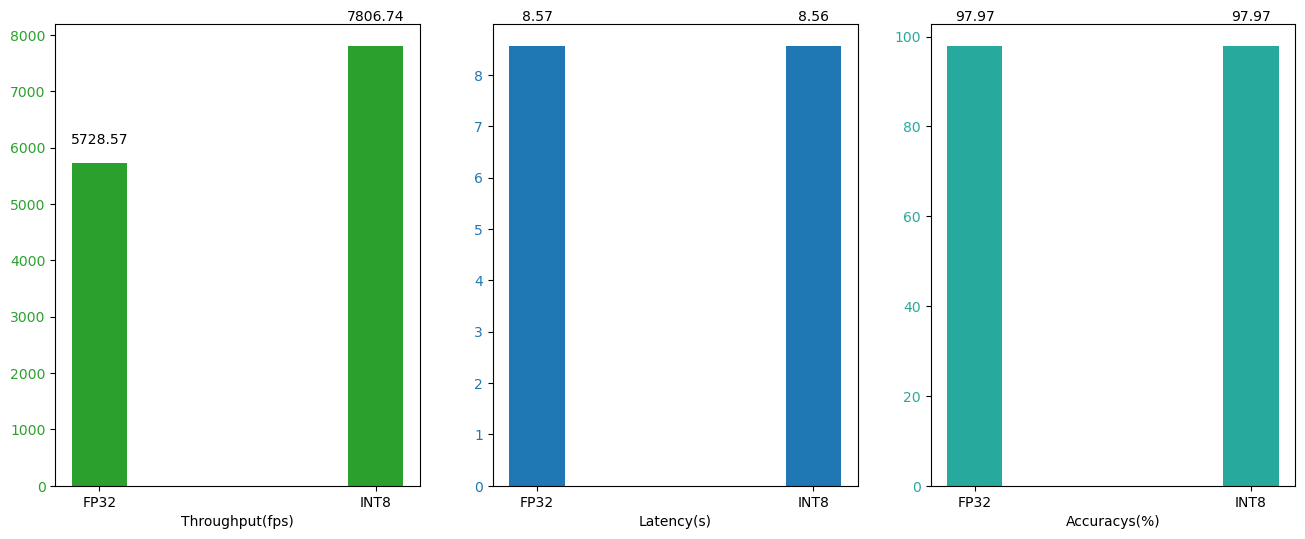

In [19]:
import json

def autolabel(ax, rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%0.2f' % float(height),
        ha='center', va='bottom')

def draw_bar(x, t, y, subplot, color, x_lab, y_lab, width=0.2):
    plt.subplot(subplot)
    plt.xticks(x, t)
    ax1 = plt.gca()
    ax1.set_xlabel(x_lab)
    ax1.set_ylabel(y_lab, color=color)
    rects1 = ax1.bar(x, y, color=color, width=width)
    ax1.tick_params(axis='y', labelcolor=color)
    autolabel(ax1, rects1)

def load_res(json_file):
    with open(json_file) as f:
        data = json.load(f)
        return data

res_32 = load_res('32.json')
res_8 = load_res('8.json')
   
accuracys = [res_32['accuracy'], res_8['accuracy']]
throughputs = [res_32['throughput'], res_8['throughput']]             
latencys = [res_32['latency'], res_8['latency']]

print('throughputs', throughputs)
print('latencys', latencys)
print('accuracys', accuracys)

accuracys_perc = [accu*100 for accu in accuracys]

t = ['FP32', 'INT8']
x = [0, 1]
plt.figure(figsize=(16,6))
draw_bar(x, t, throughputs, 131, 'tab:green', 'Throughput(fps)', '', width=0.2)
draw_bar(x, t,  latencys, 132, 'tab:blue', 'Latency(s)', '', width=0.2)
draw_bar(x, t,  accuracys_perc, 133, '#28a99d', 'Accuracys(%)', '', width=0.2)
plt.show()

### FP32 vs INT8

Compare the performance data of the INT8 model with that of the FP32 model.

throughputs_times [1, 1.3627743236693575]
latencys_times [1, 0.9997931394018065]
accuracys_times [0, 0.0]


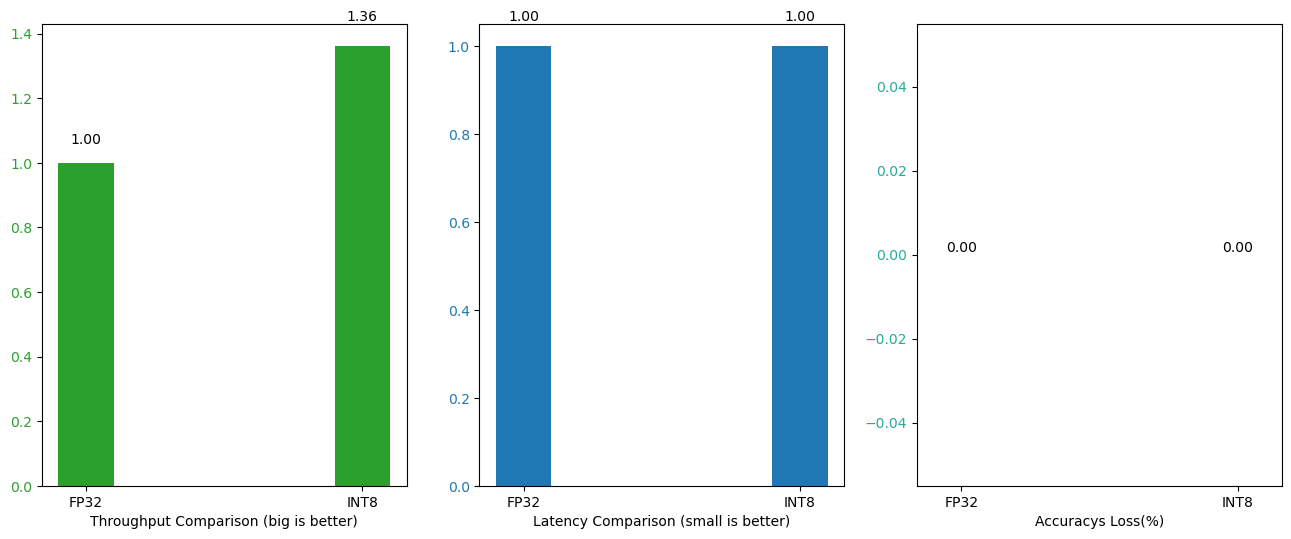

In [20]:
throughputs_times = [1, throughputs[1]/throughputs[0]]
latencys_times = [1, latencys[1]/latencys[0]]
accuracys_times = [0, accuracys_perc[1] - accuracys_perc[0]]

print('throughputs_times', throughputs_times)
print('latencys_times', latencys_times)
print('accuracys_times', accuracys_times)

plt.figure(figsize=(16,6))
draw_bar(x, t, throughputs_times, 131, 'tab:green', 'Throughput Comparison (big is better)', '', width=0.2)
draw_bar(x, t, latencys_times, 132, 'tab:blue', 'Latency Comparison (small is better)', '', width=0.2)
draw_bar(x, t, accuracys_times, 133, '#28a99d', 'Accuracys Loss(%)', '', width=0.2)
plt.show()

## Conclusion

In [21]:
print("[CODE_SAMPLE_COMPLETED_SUCCESFULLY]")

[CODE_SAMPLE_COMPLETED_SUCCESFULLY]


In this code sample we have compared performance of the FP32 and INT8 models and demonstrated that the INT8 model is faster.

The Second Generation Intel® Xeon® Scalable processors provide Intel® Deep Learning Boost that speeds up the INT8 inference.